In [1]:
import numpy as np
import torch
from torch import Tensor
from scipy.linalg import toeplitz
import scipy.sparse

import matplotlib.pyplot as plt
import seaborn as sns

from stable_baselines3.common.buffers import RolloutBuffer

sns.set()

from tqdm import trange, tqdm

In [2]:
%load_ext line_profiler

In [3]:
def exp_discount_episode(rewards: np.ndarray,
                         values: np.ndarray,
                         γ: float = 0.99) -> tuple[np.ndarray, np.ndarray]:
    
    discount_vector = np.array([[γ**t for t in range(len(rewards))]])
    
    discount_mat = np.triu(toeplitz(discount_vector))
    
    returns = discount_mat @ rewards
    
    advantages = returns - values
    
    return returns, advantages

In [4]:
def exp_kernel_discount(rewards: np.ndarray,  # Clearly a superior implementation
                        values: np.ndarray,
                        γ: float = 0.99) -> tuple[np.ndarray, np.ndarray]:

    T = len(rewards)
    discount_vector = np.array([[γ**t for t in range(len(rewards))]])
    returns = np.zeros_like(rewards)
    
    for i in range(T):
        returns[i] = discount_vector[:,:T-i] @ rewards[i:]
        
    advantages = returns - values
        
    return returns, advantages


In [5]:
def exp_slower_discount(rewards: np.ndarray,  # Clearly an inferior implementation
                        values: np.ndarray,
                        γ: float = 0.99) -> tuple[np.ndarray, np.ndarray]:
    
    returns = np.zeros_like(rewards)
    T = len(rewards)
    
    for i in range(T):
        discount_vector = np.array([[γ**t for t in range(T-i)]])

        returns[i] = discount_vector @ rewards[i:]
        
    advantages = returns - values
        
    return returns, advantages


In [6]:
def get_beta_vector(T: int,
                    α: float,
                    β: float) -> np.ndarray:
    
    discount = np.zeros((1, T))
    
    current_discount = 1
    for t in range(T):
        discount[0, t] = current_discount
        current_discount *= (α + t) / (α + β + t)
        
    return discount

def beta_kernel_discount(rewards: np.ndarray,
                         values: np.ndarray,
                         α: float = 99*100,
                         β: float = 1*100):
    T = len(rewards)
    discount_vector = get_beta_vector(T, α, β)
    returns = np.zeros_like(rewards)
    
    for i in range(T):
        returns[i] = discount_vector[:,:T-i] @ rewards[i:]
#         discount_vector = discount_vector[:, :-1]
        
    advantages = returns - values
    
    return returns, advantages


In [7]:
def alt_gae(rewards: np.ndarray,
            values: np.ndarray, 
            last_values: np.ndarray,
            γ: float = 0.99,
            λ: float = 0.95):
    
    T = len(rewards)
    advantages = np.zeros((T, 1))

    next_values = np.concatenate((values, last_values))[1:]
    
    deltas = rewards + γ * next_values - values
    
    decay_vector = np.array([[(γ * λ)**l for l in range(T)]])
    
    for t in range(T):
        advantages[t] = decay_vector[:,:T-t] @ deltas[t:]
        
    returns = advantages + values
    
    return returns, advantages

In [8]:
def gae(rewards: np.ndarray,
        values: np.ndarray,
        last_values: np.ndarray,
        dones: np.ndarray,
        final_dones: np.ndarray,
        γ: float = 0.99,
        λ: float = 0.95) -> tuple[np.ndarray, np.ndarray]:
    
    returns = np.zeros_like(rewards)
    advantages = np.zeros_like(rewards)
    
    buffer_size = rewards.shape[0]

    last_gae_lam = 0
    for step in reversed(range(buffer_size)):
        if step == buffer_size - 1:
            next_non_terminal = 1.0 - final_dones
            next_values = last_values
        else:
            next_non_terminal = 1.0 - dones[step + 1]
            next_values = values[step + 1]
                        
        delta = rewards[step] + γ * next_values * next_non_terminal - values[step]
        
        last_gae_lam = delta + γ * λ * next_non_terminal * last_gae_lam
        
        advantages[step] = last_gae_lam
        
    returns = advantages + values
    
    return returns, advantages

In [9]:
class RolloutBuffer:

    def __init__(
        self,
        buffer_size: int,
        gae_lambda: float = 1,
        gamma: float = 0.99,
        n_envs: int = 1,
    ):

        self.buffer_size = buffer_size
        self.gae_lambda = gae_lambda
        self.gamma = gamma
        self.n_envs = n_envs
        self.reset()

    def reset(self) -> None:
        self.rewards = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.returns = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.dones = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.values = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)
        self.advantages = np.zeros((self.buffer_size, self.n_envs), dtype=np.float32)

    def compute_returns_and_advantage(self, last_values: np.ndarray, dones: np.ndarray) -> None:
        """
        Post-processing step: compute the returns (sum of discounted rewards)
        and GAE advantage.
        Adapted from Stable-Baselines PPO2.

        Uses Generalized Advantage Estimation (https://arxiv.org/abs/1506.02438)
        to compute the advantage. To obtain vanilla advantage (A(s) = R - V(S))
        where R is the discounted reward with value bootstrap,
        set ``gae_lambda=1.0`` during initialization.

        :param last_values:
        :param dones:

        """
        # convert to numpy
#         last_values = last_values.clone().cpu().numpy().flatten()

        last_gae_lam = 0
        for step in reversed(range(self.buffer_size)):
            if step == self.buffer_size - 1:
                next_non_terminal = 1.0 - dones
                next_values = last_values
            else:
                next_non_terminal = 1.0 - self.dones[step + 1]
                next_values = self.values[step + 1]
            delta = self.rewards[step] + self.gamma * next_values * next_non_terminal - self.values[step]
            last_gae_lam = delta + self.gamma * self.gae_lambda * next_non_terminal * last_gae_lam
            self.advantages[step] = last_gae_lam
        self.returns = self.advantages + self.values

In [343]:
def get_beta_vector(T: int,
                    α: float,
                    β: float) -> np.ndarray:
    
    discount = np.zeros((1, T))
    
    current_discount = 1
    for t in range(T):
        discount[0, t] = current_discount
        current_discount *= (α + t) / (α + β + t)
        
    return discount

def beta_gae(rewards: np.ndarray,      # [T, N]
             values: np.ndarray,       # [T, N]
             last_values: np.ndarray,  # [1, N]
             dones: np.ndarray,        # [T, N], actually next_dones (whether previous step was terminal)
             final_dones: np.ndarray,  # [1, N]
             α: float = 99.,
             β: float = 1.,
             λ: float = 0.95):
    
    T = rewards.shape[0]
    N = rewards.shape[1]  # Number of envs
    
    advantages = np.zeros((T, N))
    
    next_non_terminal = 1-np.concatenate((dones, final_dones))[1:]
    next_values = np.concatenate((values, last_values))[1:]

    
    # Process dones
    # !!! Assume all environments have episode ends simultaneously !!!
    steps_until_eoe = np.zeros((T,), dtype=int)
    is_final = np.zeros((T,), dtype=int)  # Might be starting too early OOBE
    counter = 0
    final = 1
    done = False
    for i, d in reversed(list(enumerate(dones[:, 0]))):
        if done:
            counter = 0
            done = False
            final = 0
        steps_until_eoe[i] = counter
        is_final[i] = final
        counter += 1
        done = d
        
    
    Γ = get_beta_vector(T+1, α, β)
    lambdas = np.array([[λ**l for l in range(T)]])
    
#     γ = α / (α + β)
#     Γ = np.array([[γ**l for l in range(T+1)]])

    factor = None
    
    for i in range(T):
        steps_left = steps_until_eoe[i]
        ep_lambdas = lambdas[:,:steps_left]
        

        old_value = -values[i]
        future_rewards = (lambdas[:,:steps_left+1] * Γ[:,:steps_left+1]) @ rewards[i:i+steps_left+1]
        
        if is_final[i]:
            steps_left += 1
            
            # Fix to properly handle the very last value of an episode
            if factor is None:
                factor = np.array([[1-λ for i in range(steps_left)]]).T
                factor[-1] = 1.
            else:
                factor = factor[1:]
                        
            future_values = (lambdas[:,:steps_left] * Γ[:, 1:steps_left+1]) @ (next_values[i:i+steps_left] * next_non_terminal[i:i+steps_left] * factor[-steps_left:])

        else:
            future_values = (1-λ) * (lambdas[:,:steps_left] * Γ[:, 1:steps_left+1]) @ (next_values[i:i+steps_left] * next_non_terminal[i:i+steps_left])
        

        advantages[i] = old_value + future_rewards + future_values
        
    returns = advantages + values
    
    return returns, advantages
    
    


# Simpler test

In [344]:
%lprun -f beta_gae beta_ret, beta_adv = beta_gae(rewards, values, last_values, dones, final_dones, 9.*1e10, 1.*1e10, 0.95)

Timer unit: 1e-06 s

Total time: 0.467062 s
File: <ipython-input-343-583b20e0deeb>
Function: beta_gae at line 14

Line #      Hits         Time  Per Hit   % Time  Line Contents
    14                                           def beta_gae(rewards: np.ndarray,      # [T, N]
    15                                                        values: np.ndarray,       # [T, N]
    16                                                        last_values: np.ndarray,  # [1, N]
    17                                                        dones: np.ndarray,        # [T, N], actually next_dones (whether previous step was terminal)
    18                                                        final_dones: np.ndarray,  # [1, N]
    19                                                        α: float = 99.,
    20                                                        β: float = 1.,
    21                                                        λ: float = 0.95):
    22                                       

In [318]:
T = 2

rewards = np.array([[0. for t in range(T)]]).T
values = (np.zeros_like(rewards) + 0.5)
dones = np.zeros_like(rewards)
final_dones = np.array([[0.]])
last_values = np.array([[0.5]])

# dones = np.zeros((T, 1))
# for i in range(0,T,T//10):
#     dones[i, 0] = 1 if i > 0 else 0

In [319]:
buffer = RolloutBuffer(T, 0.95, 0.9, 1)

buffer.rewards = rewards
buffer.values = values
buffer.dones = dones


buffer.compute_returns_and_advantage(last_values, final_dones)

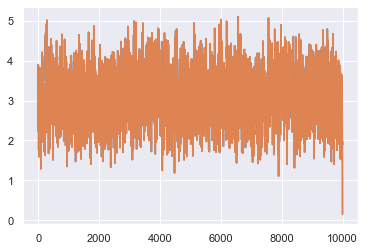

In [345]:
beta_ret, beta_adv = beta_gae(rewards, values, last_values, dones, final_dones, 9.*1e10, 1.*1e10, 0.95)

plt.plot(buffer.advantages)

plt.plot(beta_adv)

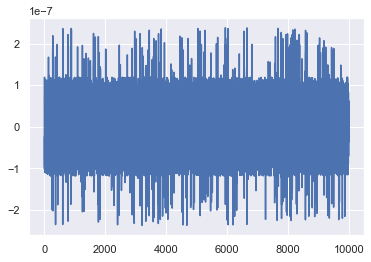

In [346]:
plt.plot(beta_adv - buffer.advantages)

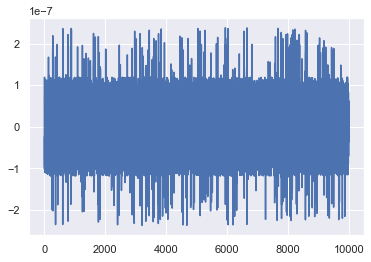

In [347]:
diff = beta_ret - buffer.returns
plt.plot(diff)

# Simple test

In [348]:
T = 100

rewards = np.array([[1. if t >= T//2 else 0. for t in range(T)]]).T
values = (np.zeros_like(rewards) + 0.5)
dones = np.zeros_like(rewards)
final_dones = np.array([[1.]])
last_values = np.array([[1.]])

dones = np.zeros((T, 1))
for i in range(0,T,T//10):
    dones[i, 0] = 1 if i > 0 else 0

In [349]:
buffer = RolloutBuffer(T, 0.95, 0.9, 1)

buffer.rewards = rewards
buffer.values = values
buffer.dones = dones


buffer.compute_returns_and_advantage(last_values, final_dones)

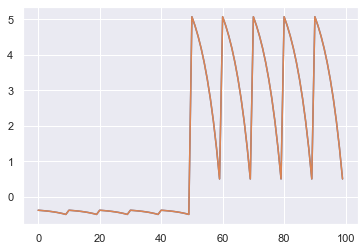

In [350]:
beta_ret, beta_adv = beta_gae(rewards, values, last_values, dones, final_dones, 9.*1e10, 1.*1e10, 0.95)

plt.plot(buffer.advantages)

plt.plot(beta_adv)

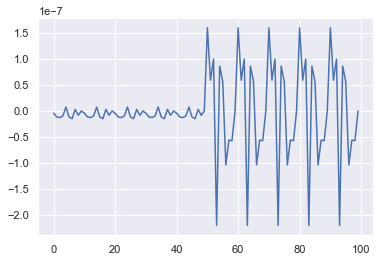

In [351]:
plt.plot(beta_adv - buffer.advantages)

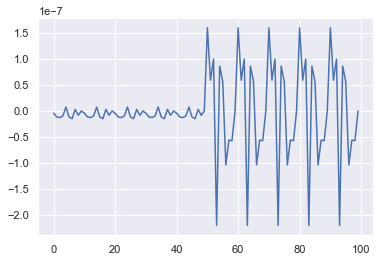

In [352]:
diff = beta_ret - buffer.returns
plt.plot(diff)

# Random test

In [363]:
T = 10000

rewards = np.random.rand(T, 1)
values = np.random.rand(T, 1)
dones = np.zeros_like(rewards)
final_dones = np.array([[1]])
last_values = np.array([[0.]])

dones = np.zeros((T, 1))
# for i in range(0,T,T//10):
#     dones[i, 0] = 1 if i > 0 else 0

In [364]:
buffer = RolloutBuffer(T, 0.95, 0.9, 1)

buffer.rewards = rewards
buffer.values = values
buffer.dones = dones


buffer.compute_returns_and_advantage(last_values, final_dones)

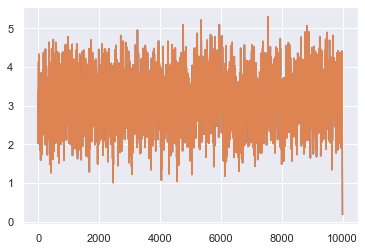

In [365]:
beta_ret, beta_adv = beta_gae(rewards, values, last_values, dones, final_dones, 1e10*9., 1e10*1., 0.95)

plt.plot(buffer.advantages)

plt.plot(beta_adv)

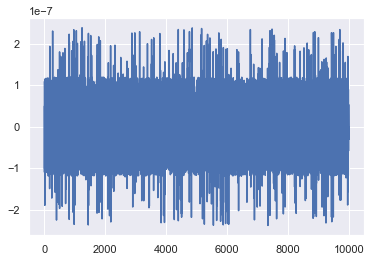

In [366]:
plt.plot(beta_adv - buffer.advantages)

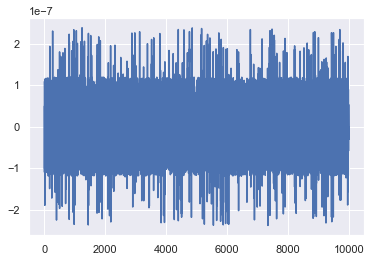

In [367]:
diff = beta_ret - buffer.returns
plt.plot(diff)

In [373]:
T = 10000

rewards = np.random.rand(T, 1)
values = np.random.rand(T, 1)
dones = np.zeros_like(rewards)
final_dones = np.array([[0]])
last_values = np.array([[0.5]])

dones = np.zeros((T, 1))
for i in range(0,T,T//10):
    dones[i, 0] = 1 if i > 0 else 0

In [374]:
N = 10

m_rewards = np.concatenate([rewards] * N, 1)
m_values = np.concatenate([values] * N, 1)
m_last_values = np.concatenate([last_values] * N, 1)
m_dones = np.concatenate([dones] * N, 1)
m_final_dones = np.concatenate([final_dones] * N, 1)

In [375]:
%%timeit
beta_gae(m_rewards, m_values, m_last_values, m_dones, m_final_dones, 99., 1., 0.95)

211 ms ± 15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [376]:
%%timeit

buffer = RolloutBuffer(T, 0.95, 0.9, N)

buffer.rewards = m_rewards
buffer.values = m_values
buffer.dones = m_dones


buffer.compute_returns_and_advantage(last_values, final_dones)

61.9 ms ± 917 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
beta_gae(m_rewards, m_values, m_last_values, m_dones, m_final_dones, 99., 1., 0.95)

In [311]:
m_dones.shape

(1000, 10)

# KINDA WORKING VERSION

In [175]:
def get_beta_vector(T: int,
                    α: float,
                    β: float) -> np.ndarray:
    
    discount = np.zeros((1, T))
    
    current_discount = 1
    for t in range(T):
        discount[0, t] = current_discount
        current_discount *= (α + t) / (α + β + t)
        
    return discount

def beta_gae(rewards: np.ndarray,      # [T, N]
             values: np.ndarray,       # [T, N]
             last_values: np.ndarray,  # [1, N]
             dones: np.ndarray,        # [T, N], actually next_dones (whether previous step was terminal)
             final_dones: np.ndarray,  # [1, N]
             α: float = 99.,
             β: float = 1.,
             λ: float = 0.95):
    
    T = rewards.shape[0]
    N = rewards.shape[1]  # Number of envs
    
    advantages = np.zeros((T, N))
    
    next_non_terminal = 1-np.concatenate((dones, final_dones))[1:]
    next_values = np.concatenate((values, last_values))[1:]

    
    # Process dones
    # !!! Assume all environments have episode ends simultaneously !!!
    steps_until_eoe = np.zeros((T,), dtype=int)
    is_final = np.zeros((T,), dtype=int)
    counter = 0
    final = 1
    done = False
    for i, d in reversed(list(enumerate(dones[:, 0]))):
        if d:
            final = 0
        if done:
            counter = 0
            done = False
        steps_until_eoe[i] = counter
        is_final[i] = final
        counter += 1
        done = d
        
    
#     Γ = get_beta_vector(T+1, α, β)
    γ = α / (α + β)
    Γ = np.array([[γ**l for l in range(T+1)]])
    lambdas = np.array([[λ**l for l in range(T)]])
    
    for i in range(T):
        steps_left = steps_until_eoe[i]
        ep_lambdas = lambdas[:,:steps_left]
        

        old_value = -values[i]
        future_rewards = (lambdas[:,:steps_left+1] * Γ[:,:steps_left+1]) @ rewards[i:i+steps_left+1]
        
        if is_final[i]:
            steps_left += 1
            
            factor = np.array([[1-λ for i in range(steps_left)]]).T
            factor[-1] = 1.
            
#             breakpoint()
            
            future_values = (lambdas[:,:steps_left] * Γ[:, 1:steps_left+1]) @ (next_values[i:i+steps_left] * next_non_terminal[i:i+steps_left] * factor[-steps_left:])
#         if i == 0:
#             steps_left += 1
#             future_values = (lambdas[:,:steps_left] * Γ[:, 1:steps_left+1]) @ (next_values[i:i+steps_left] * next_non_terminal[i:i+steps_left] * np.array([[0.05, 1]]).T)
#             breakpoint()
            
#         elif i == 1:
#             steps_left += 1
#             future_values = (lambdas[:,:steps_left] * Γ[:, 1:steps_left+1]) @ (next_values[i:i+steps_left] * next_non_terminal[i:i+steps_left])
        else:
            future_values = (1-λ) * (lambdas[:,:steps_left] * Γ[:, 1:steps_left+1]) @ (next_values[i:i+steps_left] * next_non_terminal[i:i+steps_left])
        

        advantages[i] = old_value + future_rewards + future_values
#         advantages[i] = -values[i] + \
#                         (lambdas[:,:steps_left+1] * Γ[:,:steps_left+1]) @ rewards[i:i+steps_left+1] + \
#                         (1-λ) * (lambdas[:,:steps_left] * Γ[:, 1:steps_left+1]) @ (next_values[i:i+steps_left] * next_non_terminal[i:i+steps_left])
        
        
    returns = advantages + values
    
    return returns, advantages
    
    
